In [1]:
import torch
from torch import nn
import pandas as pd
from torch.utils.data import TensorDataset, DataLoader
from d2l import torch as d2l

In [2]:
test_set_df = pd.read_csv('../data/kaggle/CaliforniaHousePrice/test.csv')
train_set_df = pd.read_csv('../data/kaggle/CaliforniaHousePrice/train.csv')

train_label_df = train_set_df['Sold Price']
train_feature_df = train_set_df.drop(labels=["Sold Price"], axis=1)
train_set_df = train_set_df.drop(labels=["Sold Price"], axis=1)

all_features = pd.concat([train_set_df.iloc[:,1:], test_set_df.iloc[:,1:]])

big_cols = []
for col in all_features.columns:
    if all_features[col].nunique() > 5000 and all_features[col].dtype == 'object':
        big_cols.append(col)
all_features = all_features.drop(labels=big_cols, axis=1)
all_features.shape


(79065, 33)

In [3]:

numeric_cols = all_features.dtypes[all_features.dtypes != 'object'].index
all_features[numeric_cols] = all_features[numeric_cols].apply(lambda x: (x - x.mean()) / x.std())
all_features[numeric_cols] = all_features[numeric_cols].fillna(0)
all_features = pd.get_dummies(all_features, dummy_na=True)


In [4]:
print(all_features.shape)

(79065, 21672)


In [9]:
train_size = 5000
train_set = torch.tensor(all_features.iloc[:train_size].values, dtype=torch.float32)
train_label = torch.tensor(train_label_df.iloc[:train_size].values, dtype=torch.float32).reshape(-1, 1)
test_set = all_features.iloc[train_set_df.shape[0]:]
test_set = torch.tensor(test_set.values, dtype=torch.float32)

In [6]:
print(train_set.shape, train_label.shape)

torch.Size([1000, 21672]) torch.Size([1000, 1])


fold 0 valid log rmse is: 0.604544, train log rmse is 0.584676
fold 1 valid log rmse is: 0.668512, train log rmse is 0.676263
fold 2 valid log rmse is: 0.656765, train log rmse is 0.616227


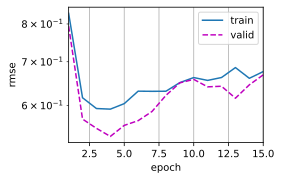

In [15]:
def getNet():
    return nn.Sequential(
        nn.Linear(21672, 1),
#         nn.ReLU(),
#         nn.Linear(10000, 1),
#         nn.ReLU(),
#         nn.Linear(500, 1),
#         nn.ReLU(),
#         nn.Linear(1000, 1)
    )

def log_rmse(a, b, loss):
#     clipped_preds = torch.clamp(a, 1, float('inf'))
    return torch.sqrt((loss(torch.log(a.abs()), torch.log(b))).mean()).item()

def get_k_fold_data(k, i, feature, label):
    fold_size = feature.shape[0] // k
    train_feature, train_label = None, None
    for j in range(k):
        fold_start = j * fold_size
        fold_end = (j + 1) * fold_size
        if i == j:
            test_feature = feature[fold_start : fold_end]
            test_label = label[fold_start : fold_end]
        elif train_feature is None:
            train_feature = feature[fold_start : fold_end]
            train_label = label[fold_start : fold_end]
        else:
            train_feature = torch.cat((train_feature, feature[fold_start : fold_end]), axis=0)
            train_label = torch.cat((train_label, label[fold_start : fold_end]), axis=0)
    return train_feature, train_label, test_feature, test_label

def train(net, lr, epochs, batch_size, weight_decay, 
          train_feature, train_label, test_feature = None, test_label = None):
    loss = nn.MSELoss()
    optimizer = torch.optim.Adam(net.parameters(), lr, weight_decay=weight_decay)
    train_l, test_l = [], []
    for epoch in range(epochs):
        data_iter = DataLoader(TensorDataset(train_feature, train_label), batch_size, shuffle=True)
        for feature, label in data_iter:
            optimizer.zero_grad()
            y_hat = net(feature)
            l = loss(label, y_hat)
            l.backward()
            optimizer.step()
        train_rmse = log_rmse(net(train_feature), train_label, loss)
        train_l.append(train_rmse)
        if test_label is not None:
            with torch.no_grad():
                test_rmse = log_rmse(net(test_feature), test_label, loss)
                test_l.append(test_rmse)
                
    return train_l, test_l

                

def fold_k():
    lr, k, batch_size, epochs, weight_decay = 1000, 3, 50, 15, 0.5
    for i in range(k):
        data = get_k_fold_data(k, i, train_set, train_label)
        net = getNet()
        train_l ,test_l = train(net, lr, epochs, batch_size, weight_decay, *data)
        print(f'fold {i} valid log rmse is: {test_l[-1]:f}, train log rmse is {train_l[-1]:f}')
        if i == 1:
            d2l.plot(list(range(1, epochs + 1)), [train_l, test_l],
                xlabel='epoch', ylabel='rmse', xlim=[1, epochs],
                legend=['train', 'valid'], yscale='log')

fold_k()





In [10]:
net = getNet()
def train_net():
    lr, epochs, batch_size, weight_decay = 1000, 10, 50, 0.1
    data = [train_set, train_label]
#     net = getNet()
    train_l ,test_l = train(net, lr, epochs, batch_size, weight_decay, *data)
    print(f'trian log rmse is:', train_l[-1])
    test_labels = net(test_set)
    test_set_df['Sold Price'] = pd.Series(test_labels.reshape(1, -1).abs().detach().numpy()[0])
    submission = pd.concat((test_set_df['Id'], test_set_df['Sold Price']), axis=1)
    submission.to_csv('../data/kaggle/CaliforniaHousePrice/submission', index=False)

train_net()

trian log rmse is: 0.5542941689491272
